<a href="https://colab.research.google.com/github/bfraiche/parkingdirty/blob/master/parking_dirty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Import some packages to use
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

#To see our directory
import os
import random
import gc   #Gabage collector for cleaning deleted data from memory

In [0]:
import requests
import zipfile
import io

pkngdrty 	= 'http://parkingdirty.com/BlockedBikeLaneTrainingSingleCam.zip'

rPd = requests.get(pkngdrty)
zPd = zipfile.ZipFile(io.BytesIO(rPd.content))
zPd.extractall()


In [58]:
# Confirm TensorFlow can see the GPU
# Select "GPU" in the Accelerator drop-down in Notebook Settings (either through the Edit menu or the command palette at cmd/ctrl-shift-P).
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [59]:
print("blocked: " + str(len([name for name in os.listdir('blocked')])))
print("not blocked: " + str(len([name for name in os.listdir('notblocked')])))

blocked: 1230
not blocked: 1230


In [0]:
train_dogs = ['blocked/{}'.format(i) for i in os.listdir('blocked')]
train_cats = ['notblocked/{}'.format(i) for i in os.listdir('notblocked')]

random.shuffle(train_dogs)
random.shuffle(train_cats)

train_imgs = train_dogs[:1000] + train_cats[:1000]  # slice the dataset and use 1000 in each class

test_imgs = train_dogs[230:] + train_cats[230:] #get test images

# #Clear lists that are useless
# del train_dogs
# del train_cats
# gc.collect()   #collect garbage to save memory

In [61]:
print(train_cats)

['notblocked/2016-09-21 195144 cam135.png', 'notblocked/2016-10-05 204736 cam135.png', 'notblocked/2016-10-12 123033 cam135.png', 'notblocked/2016-10-12 163842 cam135.png', 'notblocked/2016-09-28 191403 cam135.png', 'notblocked/2016-10-12 221212 cam135.png', 'notblocked/2016-09-21 181455 cam135.png', 'notblocked/2016-09-28 110234 cam135.png', 'notblocked/2016-10-12 164246 cam135.png', 'notblocked/2016-09-21 181051 cam135.png', 'notblocked/2016-10-05 152258 cam135.png', 'notblocked/2016-09-22 093526 cam135.png', 'notblocked/2016-09-28 164022 cam135.png', 'notblocked/2016-10-12 223434 cam135.png', 'notblocked/2016-10-12 164953 cam135.png', 'notblocked/2016-10-12 165054 cam135.png', 'notblocked/2016-09-28 225541 cam135.png', 'notblocked/2016-09-21 190231 cam135.png', 'notblocked/2016-09-21 115331 cam135.png', 'notblocked/2016-09-21 120038 cam135.png', 'notblocked/2016-09-22 104535 cam135.png', 'notblocked/2016-10-12 202837 cam135.png', 'notblocked/2016-09-21 165305 cam135.png', 'notblocke

In [64]:
foo = train_imgs[1400]

if 'not' in foo:
  print("wahoo")
else:
  print("darn")

wahoo


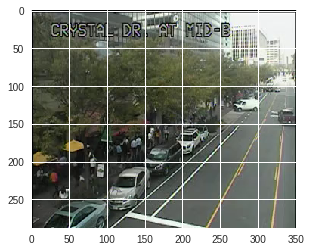

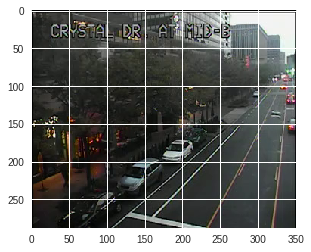

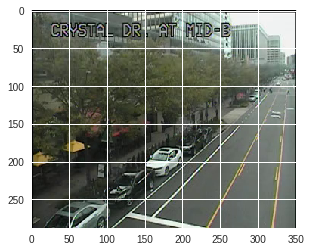

In [65]:
import matplotlib.image as mpimg
for ima in train_imgs[0:3]:
    img=mpimg.imread(ima)
    imgplot = plt.imshow(img)
    plt.show()

In [0]:
#Lets declare our image dimensions
#we are using coloured images. 
nrows = 150
ncolumns = 150
channels = 3  #change to 1 if you want to use grayscale image


#A function to read and process the images to an acceptable format for our model
def read_and_process_image(list_of_images):
    """
    Returns two arrays: 
        X is an array of resized images
        y is an array of labels
    """
    X = [] # images
    y = [] # labels
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))  #Read the image
        #get the labels
        if 'not' in image:
            y.append(1)
        else:
            y.append(0)
    
    return X, y

In [0]:
#get the train and label data
X, y = read_and_process_image(train_imgs)

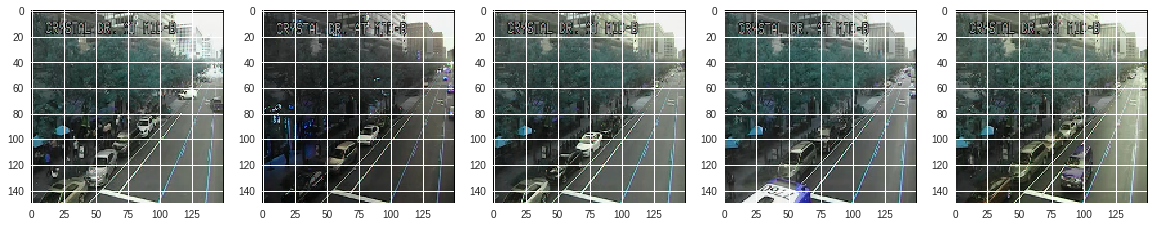

In [68]:
#Lets view some of the pics
plt.figure(figsize=(20,10))
columns = 5
for i in range(columns):
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.imshow(X[i])

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Labels for Cats and Dogs')

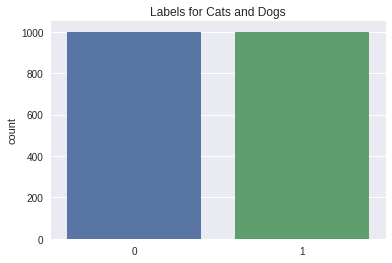

In [69]:
import seaborn as sns
# del train_imgs
# gc.collect()

#Convert list to numpy array
X = np.array(X)
y = np.array(y)

#Lets plot the label to be sure we just have two class
sns.countplot(y)
plt.title('Labels for Cats and Dogs')

In [70]:
print("Shape of train images is:", X.shape)
print("Shape of labels is:", y.shape)

Shape of train images is: (2000, 150, 150, 3)
Shape of labels is: (2000,)


In [71]:
#Lets split the data into train and test set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=2)

print("Shape of train images is:", X_train.shape)
print("Shape of validation images is:", X_val.shape)
print("Shape of labels is:", y_train.shape)
print("Shape of labels is:", y_val.shape)

Shape of train images is: (1600, 150, 150, 3)
Shape of validation images is: (400, 150, 150, 3)
Shape of labels is: (1600,)
Shape of labels is: (400,)


In [0]:
#clear memory
del X
del y
gc.collect()

#get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)

#We will use a batch size of 32. Note: batch size should be a factor of 2.***4,8,16,32,64...***
batch_size = 32

In [73]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))  #Dropout for regularization
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  #Sigmoid function at the end because we have just two classes

Using TensorFlow backend.


In [74]:
#Lets see our model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [0]:
#We'll use the RMSprop optimizer with a learning rate of 0.0001
#We'll use binary_crossentropy loss because its a binary classification
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

In [0]:

#Lets create the augmentation configuration
#This helps prevent overfitting, since we are using a small dataset
train_datagen = ImageDataGenerator(rescale=1./255,   #Scale the image between 0 and 1
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,)

val_datagen = ImageDataGenerator(rescale=1./255)  #We do not augment validation data. we only perform rescale

In [0]:
#Create the image generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [78]:
#The training part
#We train for 64 epochs with about 100 steps per epoch
history = model.fit_generator(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=64,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size)

Epoch 1/64
50/50 [==============================] - 12s 240ms/step - loss: 0.6949 - acc: 0.5075 - val_loss: 0.6909 - val_acc: 0.5391
Epoch 2/64
50/50 [==============================] - 10s 196ms/step - loss: 0.6944 - acc: 0.5069 - val_loss: 0.6978 - val_acc: 0.4565
Epoch 3/64
50/50 [==============================] - 10s 193ms/step - loss: 0.6938 - acc: 0.5100 - val_loss: 0.6963 - val_acc: 0.4565
Epoch 4/64
50/50 [==============================] - 10s 193ms/step - loss: 0.6943 - acc: 0.4862 - val_loss: 0.6968 - val_acc: 0.4429
Epoch 5/64
50/50 [==============================] - 10s 193ms/step - loss: 0.6944 - acc: 0.4881 - val_loss: 0.6966 - val_acc: 0.4538
Epoch 6/64
50/50 [==============================] - 10s 196ms/step - loss: 0.6936 - acc: 0.5069 - val_loss: 0.6931 - val_acc: 0.5353
Epoch 7/64
50/50 [==============================] - 10s 196ms/step - loss: 0.6931 - acc: 0.5081 - val_loss: 0.6960 - val_acc: 0.4755
Epoch 8/64
50/50 [==============================] - 10s 192ms/step - 

In [0]:
#Save the model
model.save_weights('model_wieghts.h5')
model.save('model_keras.h5')

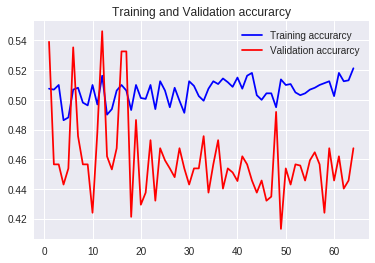

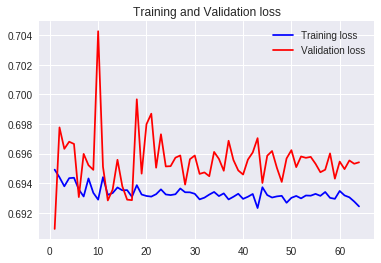

In [80]:
#lets plot the train and val curve
#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [0]:
#Now lets predict on the first 10 Images of the test set
X_test, y_test = read_and_process_image(test_imgs[0:10]) #Y_test in this case will be empty.
x = np.array(X_test)
test_datagen = ImageDataGenerator(rescale=1./255)

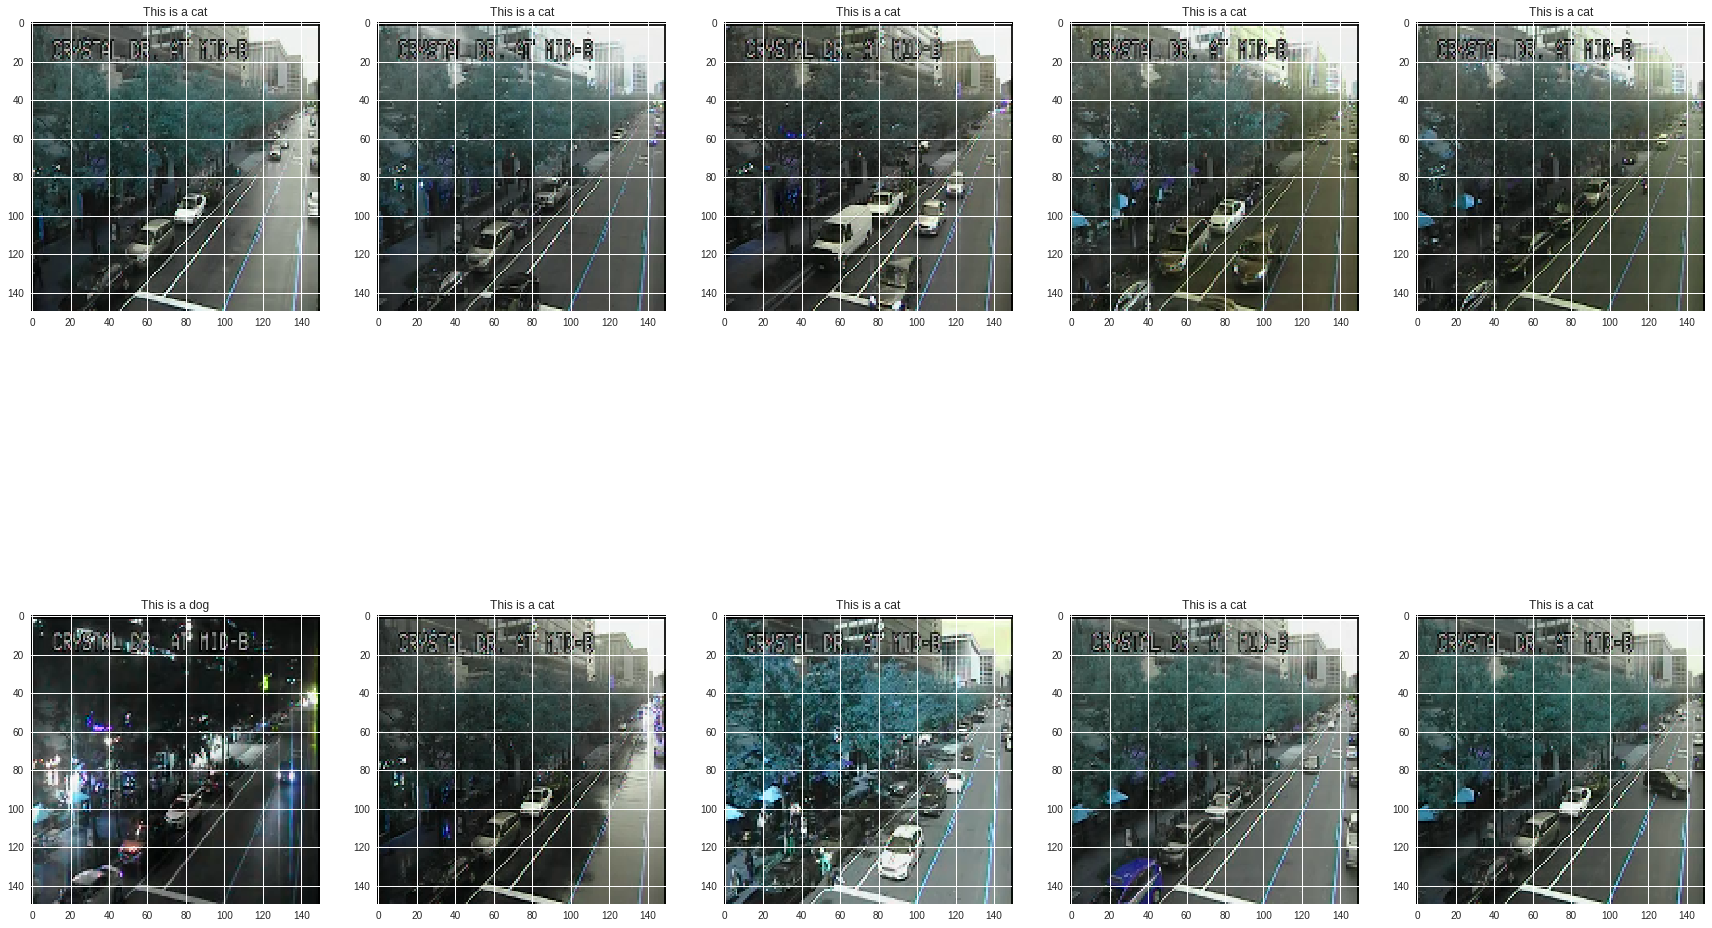

In [82]:
i = 0
text_labels = []
plt.figure(figsize=(30,20))
for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict(batch)
    if pred > 0.5:
        text_labels.append('dog')
    else:
        text_labels.append('cat')
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.title('This is a ' + text_labels[i])
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 10 == 0:
        break
plt.show()

In [0]:
# base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

# x=base_model.output
# x=GlobalAveragePooling2D()(x)
# x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
# x=Dense(1024,activation='relu')(x) #dense layer 2
# x=Dense(512,activation='relu')(x) #dense layer 3
# preds=Dense(3,activation='softmax')(x) #final layer with softmax activation

# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

# train_generator=train_datagen.flow_from_directory('./blocked/', # this is where you specify the path to the main data folder
#                                                  target_size=(352,288),
#                                                  color_mode='rgb',
#                                                  batch_size=32,
#                                                  class_mode='categorical',
#                                                  shuffle=True)

# model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# # Adam optimizer
# # loss function will be categorical cross entropy
# # evaluation metric will be accuracy

# step_size_train=train_generator.n//train_generator.batch_size
# model.fit_generator(generator=train_generator,
#                    steps_per_epoch=step_size_train,
#                    epochs=5)

# model.predict(new_image)